# AutoML for Images

### Quality Control usecase with Azure ML and AutoML for Images

<img src="https://github.com/retkowsky/AutoMLforImages/blob/main/images/capturequalitycontrol.jpg?raw=true" width=700>

## 1. Setup
> To use this notebook, **you will need to install the private preview package for AutoML for Images from the private index**.

In [1]:
#!pip install --upgrade "azureml-train-core<0.1.1" "azureml-train-automl<0.1.1" "azureml-contrib-dataset<0.1.1" --extra-index-url "https://azuremlsdktestpypi.azureedge.net/automl_for_images_private_preview/"

In [2]:
import numpy as np
import json
import os
import urllib
from zipfile import ZipFile
import seaborn as sns
import pandas as pd
from azureml.train.automl import AutoMLImageConfig
from azureml.train.hyperdrive import RandomParameterSampling
from azureml.train.hyperdrive import GridParameterSampling
from azureml.train.hyperdrive import choice

In [3]:
import sys
print("Python version =", sys.version)

Python version = 3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 19:07:31) 
[GCC 7.3.0]


In [4]:
import datetime
now = datetime.datetime.now()
print("Today =", now)

Today = 2021-05-30 20:09:11.085350


In [5]:
import azureml.core
print("You are using Azure ML version", azureml.core.VERSION)

You are using Azure ML version 0.1.0.36994775


In [6]:
# Your local platform
import platform,socket,re,uuid,json,psutil,logging

def getSystemInfo():
    try:
        info={}
        info['Platform']=platform.system()
        info['Platform-release']=platform.release()
        info['Platform-version']=platform.version()
        info['Architecture']=platform.machine()
        info['Hostname']=socket.gethostname()
        info['IP-address']=socket.gethostbyname(socket.gethostname())
        info['MAC-address']=':'.join(re.findall('..', '%012x' % uuid.getnode()))
        info['Processor']=platform.processor()
        info['RAM']=str(round(psutil.virtual_memory().total / (1024.0 **3)))+" Go"
        return json.dumps(info)
    except Exception as e:
        logging.exception(e)

json.loads(getSystemInfo())

{'Platform': 'Linux',
 'Platform-release': '5.4.0-1046-azure',
 'Platform-version': '#48~18.04.1-Ubuntu SMP Tue Apr 13 19:41:38 UTC 2021',
 'Architecture': 'x86_64',
 'Hostname': 'standardd15v2',
 'IP-address': '127.0.0.1',
 'MAC-address': '9d:e5:9a:4b:dc:ae',
 'Processor': 'x86_64',
 'RAM': '138 Go'}

## 2. Azure ML workspace setup
In order to train and deploy models in Azure ML, you will first need to set up a workspace.

An [Azure ML Workspace](https://docs.microsoft.com/en-us/azure/machine-learning/concept-azure-machine-learning-architecture#workspace) is an Azure resource that organizes and coordinates the actions of many other Azure resources to assist in executing and sharing machine learning workflows. In particular, an Azure ML Workspace coordinates storage, databases, and compute resources providing added functionality for machine learning experimentation, deployment, inference, and the monitoring of deployed models.

Create an Azure ML Workspace within your Azure subscription, or load an existing workspace.

In [7]:
## specify workspace parameters
subscription_id='tobereplaced'   
resource_group='automlvision-rg'   
workspace_name='automlvision'

from azureml.core.workspace import Workspace
ws = Workspace.create(name=workspace_name,
                      subscription_id=subscription_id,
                      resource_group=resource_group, 
                      exist_ok=True)

In [8]:
from azureml.core import Workspace
ws = Workspace.from_config()

In [9]:
ws.name, ws.resource_group

('automlvision', 'automlvision-rg')

## 3. GPU Compute target setup
You will need to provide a [Compute Target](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture#compute-target) that will be used for your AutoML model training. AutoML models for image tasks require GPU SKUs and support NC and ND families. We recommend using the NCsv3-series (with v100 GPUs) for faster training. Using a compute target with a multi-GPU VM SKU will leverage the multiple GPUs to speed up training. Additionally, setting up a compute target with multiple nodes will allow for faster model training by leveraging parallelism, when tuning hyperparameters for your model.

In [10]:
from azureml.core.compute import AmlCompute, ComputeTarget

cluster_name = "gpuqualityctrl"

try:
    compute_target = ws.compute_targets[cluster_name]
    print('Found existing compute target.')
except KeyError:
    print('Creating a new compute target...')
    compute_config = AmlCompute.provisioning_configuration(vm_size='Standard_NC6', 
                                                           idle_seconds_before_scaledown=1800,
                                                           min_nodes=0, 
                                                           max_nodes=4)

    compute_target = ComputeTarget.create(ws, cluster_name, compute_config)
    
# Can poll for a minimum number of nodes and for a specific timeout.
# If no min_node_count is provided, it will use the scale settings for the cluster.
compute_target.wait_for_completion(show_output=True, min_node_count=None, timeout_in_minutes=20)

Creating a new compute target...
Creating.........
SucceededProvisioning operation finished, operation "Succeeded"
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


In [11]:
# Compute status
compute_target.provisioning_state

'Succeeded'

In [12]:
# Compute cluster information
compute_target.get_status().serialize()

{'currentNodeCount': 0,
 'targetNodeCount': 0,
 'nodeStateCounts': {'preparingNodeCount': 0,
  'runningNodeCount': 0,
  'idleNodeCount': 0,
  'unusableNodeCount': 0,
  'leavingNodeCount': 0,
  'preemptedNodeCount': 0},
 'allocationState': 'Steady',
 'allocationStateTransitionTime': '2021-05-30T20:09:50.653000+00:00',
 'errors': None,
 'creationTime': '2021-05-30T20:09:18.131404+00:00',
 'modifiedTime': '2021-05-30T20:10:03.608327+00:00',
 'provisioningState': 'Succeeded',
 'provisioningStateTransitionTime': None,
 'scaleSettings': {'minNodeCount': 0,
  'maxNodeCount': 4,
  'nodeIdleTimeBeforeScaleDown': 'PT1800S'},
 'vmPriority': 'Dedicated',
 'vmSize': 'STANDARD_NC6'}

In [13]:
compute_target.vm_size

'STANDARD_NC6'

## 4. Experiment Setup
Create an [Experiment](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture#experiment) in your workspace to track your model training runs

In [14]:
from azureml.core import Experiment

experiment_name = 'AutomlImages-QualityControl' 
experiment = Experiment(ws, name=experiment_name)

In [15]:
experiment

Experiment(Name: AutomlImages-QualityControl,
Workspace: automlvision)

## 5. Dataset with input Training Data
In order to generate models for computer vision, you will need to bring in labeled image data as input for model training in the form of an AzureML Labeled Dataset. You can either use a Labeled Dataset that you have exported from a Data Labeling project, or create a new Labeled Dataset with your labeled training data

In [16]:
from azureml.core import Workspace, Dataset
import azureml.contrib.dataset

dataset = Dataset.get_by_name(ws, name='Flasks_20210530_182833')
df=dataset.to_pandas_dataframe()

In [17]:
df.shape

(105, 3)

In [18]:
df.dtypes

image_url           object
label               object
label_confidence    object
dtype: object

In [19]:
df

image_url  \
0    StreamInfo(AmlDatastore://OK (38).JPG[{'subscr...   
1    StreamInfo(AmlDatastore://KO (37).JPG[{'subscr...   
2    StreamInfo(AmlDatastore://OK (15).JPG[{'subscr...   
3    StreamInfo(AmlDatastore://OK (44).JPG[{'subscr...   
4    StreamInfo(AmlDatastore://OK (31).JPG[{'subscr...   
..                                                 ...   
100  StreamInfo(AmlDatastore://OK (49).JPG[{'subscr...   
101  StreamInfo(AmlDatastore://OK (53).JPG[{'subscr...   
102  StreamInfo(AmlDatastore://OK (52).JPG[{'subscr...   
103  StreamInfo(AmlDatastore://OK (50).JPG[{'subscr...   
104  StreamInfo(AmlDatastore://OK (51).JPG[{'subscr...   

                                                 label label_confidence  
0    [{'label': 'Cap OK', 'topX': 0.410597278225806...            [1.0]  
1    [{'label': 'Cap KO', 'topX': 0.325919858870967...            [1.0]  
2    [{'label': 'Cap OK', 'topX': 0.390435987903225...            [1.0]  
3    [{'label': 'Cap OK', 'topX': 0.396484375, 'top...            [1.0]  
4    [{'label': 'Cap OK', 'topX': 0.440839213709677...            [1.0]  
..                                                 ...              ...  
100  [{'label': 'Cap OK', 'topX': 0.382371471774193...            [1.0]  
101  [{'label': 'Cap OK', 'topX': 0.400516633064516...            [1.0]  
102  [{'label': 'Cap OK', 'topX': 0.410597278225806...            [1.0]  
103  [{'label': 'Cap OK', 'topX': 0.374306955645161...            [1.0]  
104  [{'label': 'Cap OK', 'topX': 0.404548891129032...            [1.0]  

[105 rows x 3 columns]

In [20]:
training_dataset=dataset

## 6. Configuring your AutoML run for image tasks
AutoML allows you to easily train models for Image Classification, Object Detection & Instance Segmentation on your image data. You can control the model algorithm to be used, specify hyperparameter values for your model as well as perform a sweep across the hyperparameter space to generate an optimal model. Parameters for configuring your AutoML runs for image related tasks are specified using the `AutoMLImageConfig` - please refer to the [documentation](https://github.com/swatig007/automlForImages/blob/main/README.md) for the details on the parameters that can be used and their values.

When using AutoML for image tasks, you need to specify the model algorithms using the `model_name` parameter. You can either specify a single model or choose to sweep over multiple ones. 
Currently supported model algorithms for object detection:`yolov5`, `fasterrcnn_resnet50_fpn`, `fasterrcnn_resnet34_fpn`, `fasterrcnn_resnet18_fpn`, `retinanet_resnet50_fpn`.

### Using default hyperparameter values for the specified algorithm
Before doing a large sweep to search for the optimal models and hyperparameters, we recommend trying the default values to get a first baseline. Next, you can explore multiple hyperparameters for the same model before sweeping over multiple models and their parameters. This is for employing a more iterative approach, because with multiple models and multiple hyperparameters for each (as we showcase in the next section), the search space grows exponentially and you need more iterations to find optimal configurations.

If you wish to use the default hyperparameter values for a given algorithm (say `yolov5`), you can specify the config for your AutoML Image runs as follows:

In [21]:
from azureml.train.automl import AutoMLImageConfig
from azureml.train.hyperdrive import GridParameterSampling
from azureml.train.hyperdrive import choice

image_config = AutoMLImageConfig(task='image-object-detection',
                                 compute_target=compute_target,
                                 training_data=training_dataset,
                                 hyperparameter_sampling=GridParameterSampling({'model_name': choice('yolov5')}))

### Submitting an AutoML run for Image tasks 
Once you've created the config settings for your run, you can submit an AutoML run using the config in order to train an image model using your training dataset.

In [22]:
automl_image_run = experiment.submit(image_config)

Submitting remote run.


In [23]:
automl_image_run.wait_for_completion(wait_post_processing=True)

{'runId': 'AutoML_ce26138a-40dc-42a9-b612-8a172897d335',
 'target': 'gpuqualityctrl',
 'status': 'Completed',
 'startTimeUtc': '2021-05-30T20:10:26.037064Z',
 'endTimeUtc': '2021-05-30T20:27:42.777538Z',
 'properties': {'num_iterations': '1',
  'training_type': 'TrainFull',
  'acquisition_function': 'EI',
  'primary_metric': 'mean_average_precision',
  'train_split': '0',
  'acquisition_parameter': '0',
  'num_cross_validation': None,
  'target': 'gpuqualityctrl',
  'AMLSettingsJsonString': '{"path":null,"name":"AutomlImages-QualityControl","subscription_id":"70b8f39e-8863-49f7-b6ba-34a80799550c","resource_group":"automlvision-rg","workspace_name":"automlvision","region":"westeurope","compute_target":"gpuqualityctrl","spark_service":null,"azure_service":"remote","many_models":false,"pipeline_fetch_max_batch_size":1,"enable_batch_run":false,"enable_run_restructure":false,"start_auxiliary_runs_before_parent_complete":false,"enable_code_generation":false,"iterations":1,"primary_metric":"m

In [24]:
experiment

Experiment(Name: AutomlImages-QualityControl,
Workspace: automlvision)

In [25]:
# List of all the AutoML for Images metrics values
automlvisionmetrics = automl_image_run.get_metrics()
metricsdf=pd.DataFrame(automl_image_run.get_metrics()) # Convert to a pandas df
metricsdf

per_label_metrics  precision  \
0   {0: {'precision': -1.0, 'recall': 0.0, 'averag...        NaN   
1   {0: {'precision': -1.0, 'recall': 0.0, 'averag...        NaN   
2   {0: {'precision': 0.0, 'recall': 0.0, 'average...      0.038   
3   {0: {'precision': 0.0, 'recall': 0.0, 'average...      0.000   
4   {0: {'precision': 0.0, 'recall': 0.0, 'average...      0.003   
5   {0: {'precision': 0.0, 'recall': 0.0, 'average...      0.022   
6   {0: {'precision': 0.058, 'recall': 1.0, 'avera...      0.059   
7   {0: {'precision': 0.069, 'recall': 1.0, 'avera...      0.138   
8   {0: {'precision': 0.043, 'recall': 1.0, 'avera...      0.084   
9   {0: {'precision': 0.258, 'recall': 1.0, 'avera...      0.222   
10  {0: {'precision': 0.216, 'recall': 1.0, 'avera...      0.246   
11  {0: {'precision': 0.348, 'recall': 1.0, 'avera...      0.516   
12  {0: {'precision': 0.364, 'recall': 1.0, 'avera...      0.453   
13  {0: {'precision': 0.667, 'recall': 1.0, 'avera...      0.504   
14  {0: {'precision': 0.471, 'recall': 1.0, 'avera...      0.485   
15  {0: {'precision': 0.8, 'recall': 1.0, 'average...      0.900   
16  {0: {'precision': 0.727, 'recall': 1.0, 'avera...      0.614   
17  {0: {'precision': 1.0, 'recall': 1.0, 'average...      1.000   

    mean_average_precision  recall  
0                    0.000   0.000  
1                    0.000   0.000  
2                    0.283   0.423  
3                    0.000   0.038  
4                    0.002   0.269  
5                    0.192   0.462  
6                    0.822   1.000  
7                    0.833   1.000  
8                    0.921   1.000  
9                    0.886   1.000  
10                   0.659   1.000  
11                   1.000   1.000  
12                   0.913   1.000  
13                   1.000   1.000  
14                   0.993   1.000  
15                   1.000   1.000  
16                   1.000   1.000  
17                   1.000   1.000

In [26]:
metricsdf.sort_values(by='mean_average_precision', ascending=False)

per_label_metrics  precision  \
17  {0: {'precision': 1.0, 'recall': 1.0, 'average...      1.000   
16  {0: {'precision': 0.727, 'recall': 1.0, 'avera...      0.614   
15  {0: {'precision': 0.8, 'recall': 1.0, 'average...      0.900   
13  {0: {'precision': 0.667, 'recall': 1.0, 'avera...      0.504   
11  {0: {'precision': 0.348, 'recall': 1.0, 'avera...      0.516   
14  {0: {'precision': 0.471, 'recall': 1.0, 'avera...      0.485   
8   {0: {'precision': 0.043, 'recall': 1.0, 'avera...      0.084   
12  {0: {'precision': 0.364, 'recall': 1.0, 'avera...      0.453   
9   {0: {'precision': 0.258, 'recall': 1.0, 'avera...      0.222   
7   {0: {'precision': 0.069, 'recall': 1.0, 'avera...      0.138   
6   {0: {'precision': 0.058, 'recall': 1.0, 'avera...      0.059   
10  {0: {'precision': 0.216, 'recall': 1.0, 'avera...      0.246   
2   {0: {'precision': 0.0, 'recall': 0.0, 'average...      0.038   
5   {0: {'precision': 0.0, 'recall': 0.0, 'average...      0.022   
4   {0: {'precision': 0.0, 'recall': 0.0, 'average...      0.003   
1   {0: {'precision': -1.0, 'recall': 0.0, 'averag...        NaN   
3   {0: {'precision': 0.0, 'recall': 0.0, 'average...      0.000   
0   {0: {'precision': -1.0, 'recall': 0.0, 'averag...        NaN   

    mean_average_precision  recall  
17                   1.000   1.000  
16                   1.000   1.000  
15                   1.000   1.000  
13                   1.000   1.000  
11                   1.000   1.000  
14                   0.993   1.000  
8                    0.921   1.000  
12                   0.913   1.000  
9                    0.886   1.000  
7                    0.833   1.000  
6                    0.822   1.000  
10                   0.659   1.000  
2                    0.283   0.423  
5                    0.192   0.462  
4                    0.002   0.269  
1                    0.000   0.000  
3                    0.000   0.038  
0                    0.000   0.000

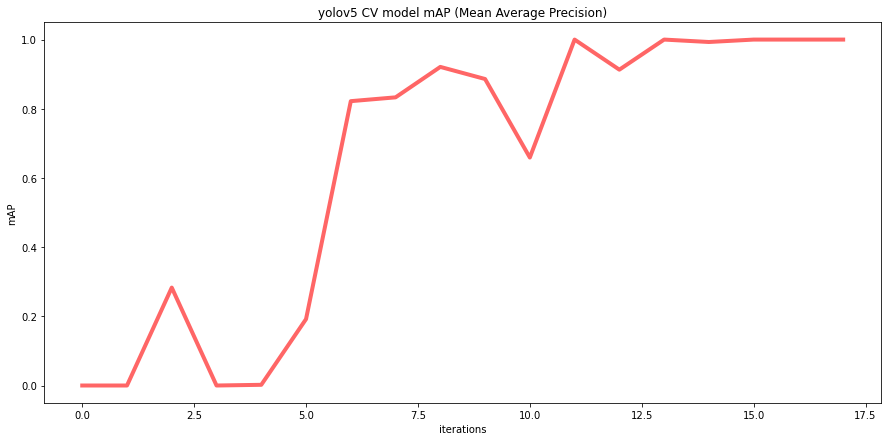

In [27]:
# Let's plot the accuracy metric for the CV model, save the graph to a jpg file and log it to the Azure ML experiment
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize = (15,7))
plt.plot(automlvisionmetrics['mean_average_precision'], 'r-', lw=4, alpha=.6)
plt.xlabel('iterations', fontsize=10)
plt.ylabel('mAP', fontsize=10)
plt.title('yolov5 CV model mAP (Mean Average Precision)', fontsize=12)

plt.savefig('yolov5.jpg', dpi=150) # Saving image in a jpg file
automl_image_run.log_image(name='yolov5.jpg', plot=plt) # Logging the graph into the Azure ML experiment

plt.show()

In [28]:
# Checking the file
!ls yolov5.jpg -l

-rwxrwxrwx 1 root root 110917 May 30 20:27 yolov5.jpg


### Hyperparameter sweeping for your AutoML models for image tasks (optional)

In this example, we use the AutoMLImageConfig to train an Object Detection model using `yolov5` and `fasterrcnn_resnet50_fpn`, both of which are pretrained on COCO, a large-scale object detection, segmentation, and captioning dataset that contains over 200K labeled images with over 80 label cateogories.

When using AutoML for image tasks, you can perform a hyperparameter sweep over a defined parameter space, to find the optimal model. In this example, we sweep over the hyperparameters for each algorithm, choosing from a range of values for `learning_rate`, `optimizer`, `lr_scheduler`, etc, to generate a model with the optimal primary metric. If hyperparameter values are not specified, then default values are used for the specified algorithm.  

We use Random Sampling to pick samples from this parameter space and try a total of 20 iterations with these different samples, running 4 iterations at a time on our compute target, which has been previously set up using 4 nodes. Please note that the more parameters the space has, the more iterations you need to find optimal models.  

We also leverage the Bandit early termination policy that terminates poor performing configs (those that are not within 20% slack of the best perfroming config), thus significantly saving compute resources.

from azureml.train.automl import AutoMLImageConfig
from azureml.train.hyperdrive import GridParameterSampling, RandomParameterSampling, BayesianParameterSampling
from azureml.train.hyperdrive import BanditPolicy, HyperDriveConfig, PrimaryMetricGoal
from azureml.train.hyperdrive import choice, uniform

parameter_space = {
    'model': choice(
        {
            'model_name': choice('yolov5'),
            'learning_rate': uniform(0.0001, 0.001),
            'img_size': choice(380, 512, 640), # model-specific
        },
        {
            'model_name': choice('fasterrcnn_resnet50_fpn'),
            'learning_rate': uniform(0.0001, 0.001),
            'optimizer': choice('sgd', 'adam', 'adamw'),
            'min_size': choice(380, 512, 640), # model-specific
        }
    )
}

tuning_settings = {
    'iterations': 10, 
    'max_concurrent_iterations': 4, 
    'hyperparameter_sampling': RandomParameterSampling(parameter_space),  
    'policy': BanditPolicy(evaluation_interval=2, slack_factor=0.2, delay_evaluation=6)
}


automl_image_config = AutoMLImageConfig(task='image-object-detection',
                                        compute_target=compute_target,
                                        training_data=training_dataset,
                                        primary_metric='mean_average_precision',
                                        **tuning_settings)

automl_image_run = experiment.submit(automl_image_config)

automl_image_run.wait_for_completion(wait_post_processing=True)

When doing a hyperparameter sweep, it can be useful to visualize the different configurations that were tried using the HyperDrive UI. You can navigate to this UI by going to the 'Child runs' tab in the UI of the main `automl_image_run` from above, which is the HyperDrive parent run. Then you can go into the 'Child runs' tab of this one. Alternatively, here below you can see directly the HyperDrive parent run and navigate to its 'Child runs' tab: 

In [29]:
from azureml.core import Run
hyperdrive_run = Run(experiment=experiment, run_id=automl_image_run.id + '_HD')
hyperdrive_run

Run(Experiment: AutomlImages-QualityControl,
Id: AutoML_ce26138a-40dc-42a9-b612-8a172897d335_HD,
Type: hyperdrive,
Status: Completed)

## 7. Register the optimal model from the AutoML run
Once the run completes, we can register the model that was created from the best run (configuration that resulted in the best primary metric)

In [30]:
# Defining tags for the custom vision model
cvmodel_tags={"Data": "Images", 
              "Context" : "Quality Control",
              "Computer Vision" : "True",
              "Task" : "Best AutoML Images",
              "Framework" : "AzureML AutoML for Images",
              "AutoML Metric" : "mAP"}

In [31]:
# Register the model from the best run

best_child_run = automl_image_run.get_best_child()
model_name = best_child_run.properties['model_name']

model = best_child_run.register_model(model_name = model_name, 
                                      model_path='outputs/model.pt',
                                      tags=cvmodel_tags,
                                      description="Quality Control")

In [32]:
model

Model(workspace=Workspace.create(name='automlvision', subscription_id='70b8f39e-8863-49f7-b6ba-34a80799550c', resource_group='automlvision-rg'), name=AutoMLce26138a40, id=AutoMLce26138a40:1, version=1, tags={'Data': 'Images', 'Context': 'Quality Control', 'Computer Vision': 'True', 'Task': 'Best AutoML Images', 'Framework': 'AzureML AutoML for Images', 'AutoML Metric': 'mAP'}, properties={})

In [33]:
model.id

'AutoMLce26138a40:1'

In [34]:
model.tags

{'Data': 'Images',
 'Context': 'Quality Control',
 'Computer Vision': 'True',
 'Task': 'Best AutoML Images',
 'Framework': 'AzureML AutoML for Images',
 'AutoML Metric': 'mAP'}

In [35]:
# We can download the CV model
model.download(target_dir='.', exist_ok=True)

'model.pt'

In [36]:
!ls *.pt -l

-rwxrwxrwx 1 root root 172343232 May 30 20:27 model.pt


## 8. Deploy model as a web service
Once you have your trained model, you can deploy the model on Azure. You can deploy your trained model as a web service on Azure Container Instances ([ACI](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-deploy-azure-container-instance)) or Azure Kubernetes Service ([AKS](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-deploy-azure-kubernetes-service)). ACI is the perfect option for testing deployments, while AKS is better suited for for high-scale, production usage.  
In this tutorial, we will deploy the model as a web service in AKS.

You will need to first create an AKS compute cluster, or use an existing AKS cluster. You can use either GPU or CPU VM SKUs for your deployment cluster

In [37]:
from azureml.core.compute import ComputeTarget, AksCompute
from azureml.exceptions import ComputeTargetException

# Choose a name for your cluster
aks_name = "cluster-aks-gpu"

# Check to see if the cluster already exists
try:
    aks_target = ComputeTarget(workspace=ws, name=aks_name)
    print("Found existing compute target. So let's use it")
except ComputeTargetException:
    print('Creating a new compute target...')
    # Provision AKS cluster with GPU machine
    prov_config = AksCompute.provisioning_configuration(vm_size="STANDARD_NC6", 
                                                        location="eastus2")
    # Create the cluster
    aks_target = ComputeTarget.create(workspace=ws, 
                                      name=aks_name, 
                                      provisioning_configuration=prov_config)
    aks_target.wait_for_completion(show_output=True)

Found existing compute target. So let's use it


Next, you will need to define the inference configuration, that describes how to set up the web-service containing your model. You can use the scoring script and the environment from the training run in your inference config.  
You can then deploy the model as an AKS web service.

In [38]:
# Deploy the model from the best run as an AKS web service
from azureml.core.model import InferenceConfig
from azureml.core.webservice import AksWebservice
from azureml.core.webservice import Webservice
from azureml.core.model import Model
from azureml.core.environment import Environment

best_child_run.download_file('outputs/scoring_file_v_1_0_0.py', output_file_path='score.py')
environment = best_child_run.get_environment()
inference_config = InferenceConfig(entry_script='score.py', environment=environment)


aks_name='automlqualitycontrol'

aks_tags={"Data": "Images", 
          "Topic" : "Quality Control Custom Vision model", 
          'Task' : 'Object Detection',
          "Framework" : "AutoML Images best model", 
          "AKS" : "True"}

aks_description="Object Detection CV model to detect and identify quality control issues with flasks"

aks_config = AksWebservice.deploy_configuration(autoscale_enabled=True,                                                    
                                                cpu_cores=1,
                                                memory_gb=50,
                                                enable_app_insights=True,
                                                description=aks_description,
                                                tags=aks_tags)

aks_service = Model.deploy(ws,
                           models=[model],
                           inference_config=inference_config,
                           deployment_config=aks_config,
                           deployment_target=aks_target,
                           name=aks_name,
                           overwrite=True)

aks_service.wait_for_deployment(show_output=True)
print()
print("Done. Model is deployed.")
print("\nAKS service status=", aks_service.state)

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running
2021-05-30 20:28:05+00:00 Creating Container Registry if not exists.
2021-05-30 20:28:05+00:00 Registering the environment.
2021-05-30 20:28:06+00:00 Use the existing image..
2021-05-30 20:28:09+00:00 Creating resources in AKS.
2021-05-30 20:28:12+00:00 Submitting deployment to compute.
2021-05-30 20:28:13+00:00 Checking the status of deployment automlqualitycontrol..
2021-05-30 20:28:56+00:00 Checking the status of inference endpoint automlqualitycontrol.
Succeeded
AKS service creation operation finished, operation "Succeeded"

Done. Model is deployed.

AKS service status= Healthy


> It usually took less than 10 minutes to deploy the computer vision model.

## 9. Test the web service
Finally, let's test our deployed web service to predict new images. You can pass in any image. In this case, we'll use a random image from the dataset and pass it to te scoring URI.

In [39]:
print("Computer Vision model endpoint:", aks_service.scoring_uri)

Computer Vision model endpoint: http://52.177.142.119:80/api/v1/service/automlqualitycontrol/score


In [40]:
print("Computer Vision model service status=", aks_service.state)

Computer Vision model service status= Healthy


In [41]:
print("Computer Vision model endpoint properties:", aks_service.properties)

Computer Vision model endpoint properties: {'hasInferenceSchema': 'False', 'hasHttps': 'False'}


In [42]:
print("Computer Vision model endpoint tags:", aks_service.tags)

Computer Vision model endpoint tags: {'Data': 'Images', 'Topic': 'Quality Control Custom Vision model', 'Task': 'Object Detection', 'Framework': 'AutoML Images best model', 'AKS': 'True'}


### Let's download some images to test our model.

## Test 1

In [61]:
import urllib
image_url = 'https://github.com/retkowsky/AutoMLforImages/blob/main/images/CapTest1.jpg?raw=true'
image_file = 'test1.jpg'
urllib.request.urlretrieve(image_url, filename=image_file)
print("Image is downloaded and ready to be predicted.")

Image is downloaded and ready to be predicted.


In [62]:
import cv2 as cv
img = cv.imread(image_file)
print("Image informations:")
print("- Image filename:", image_file)
print("- Image shape:", img.shape)
print("- Image size:", img.size)

Image informations:
- Image filename: test1.jpg
- Image shape: (3284, 3009, 3)
- Image size: 29644668


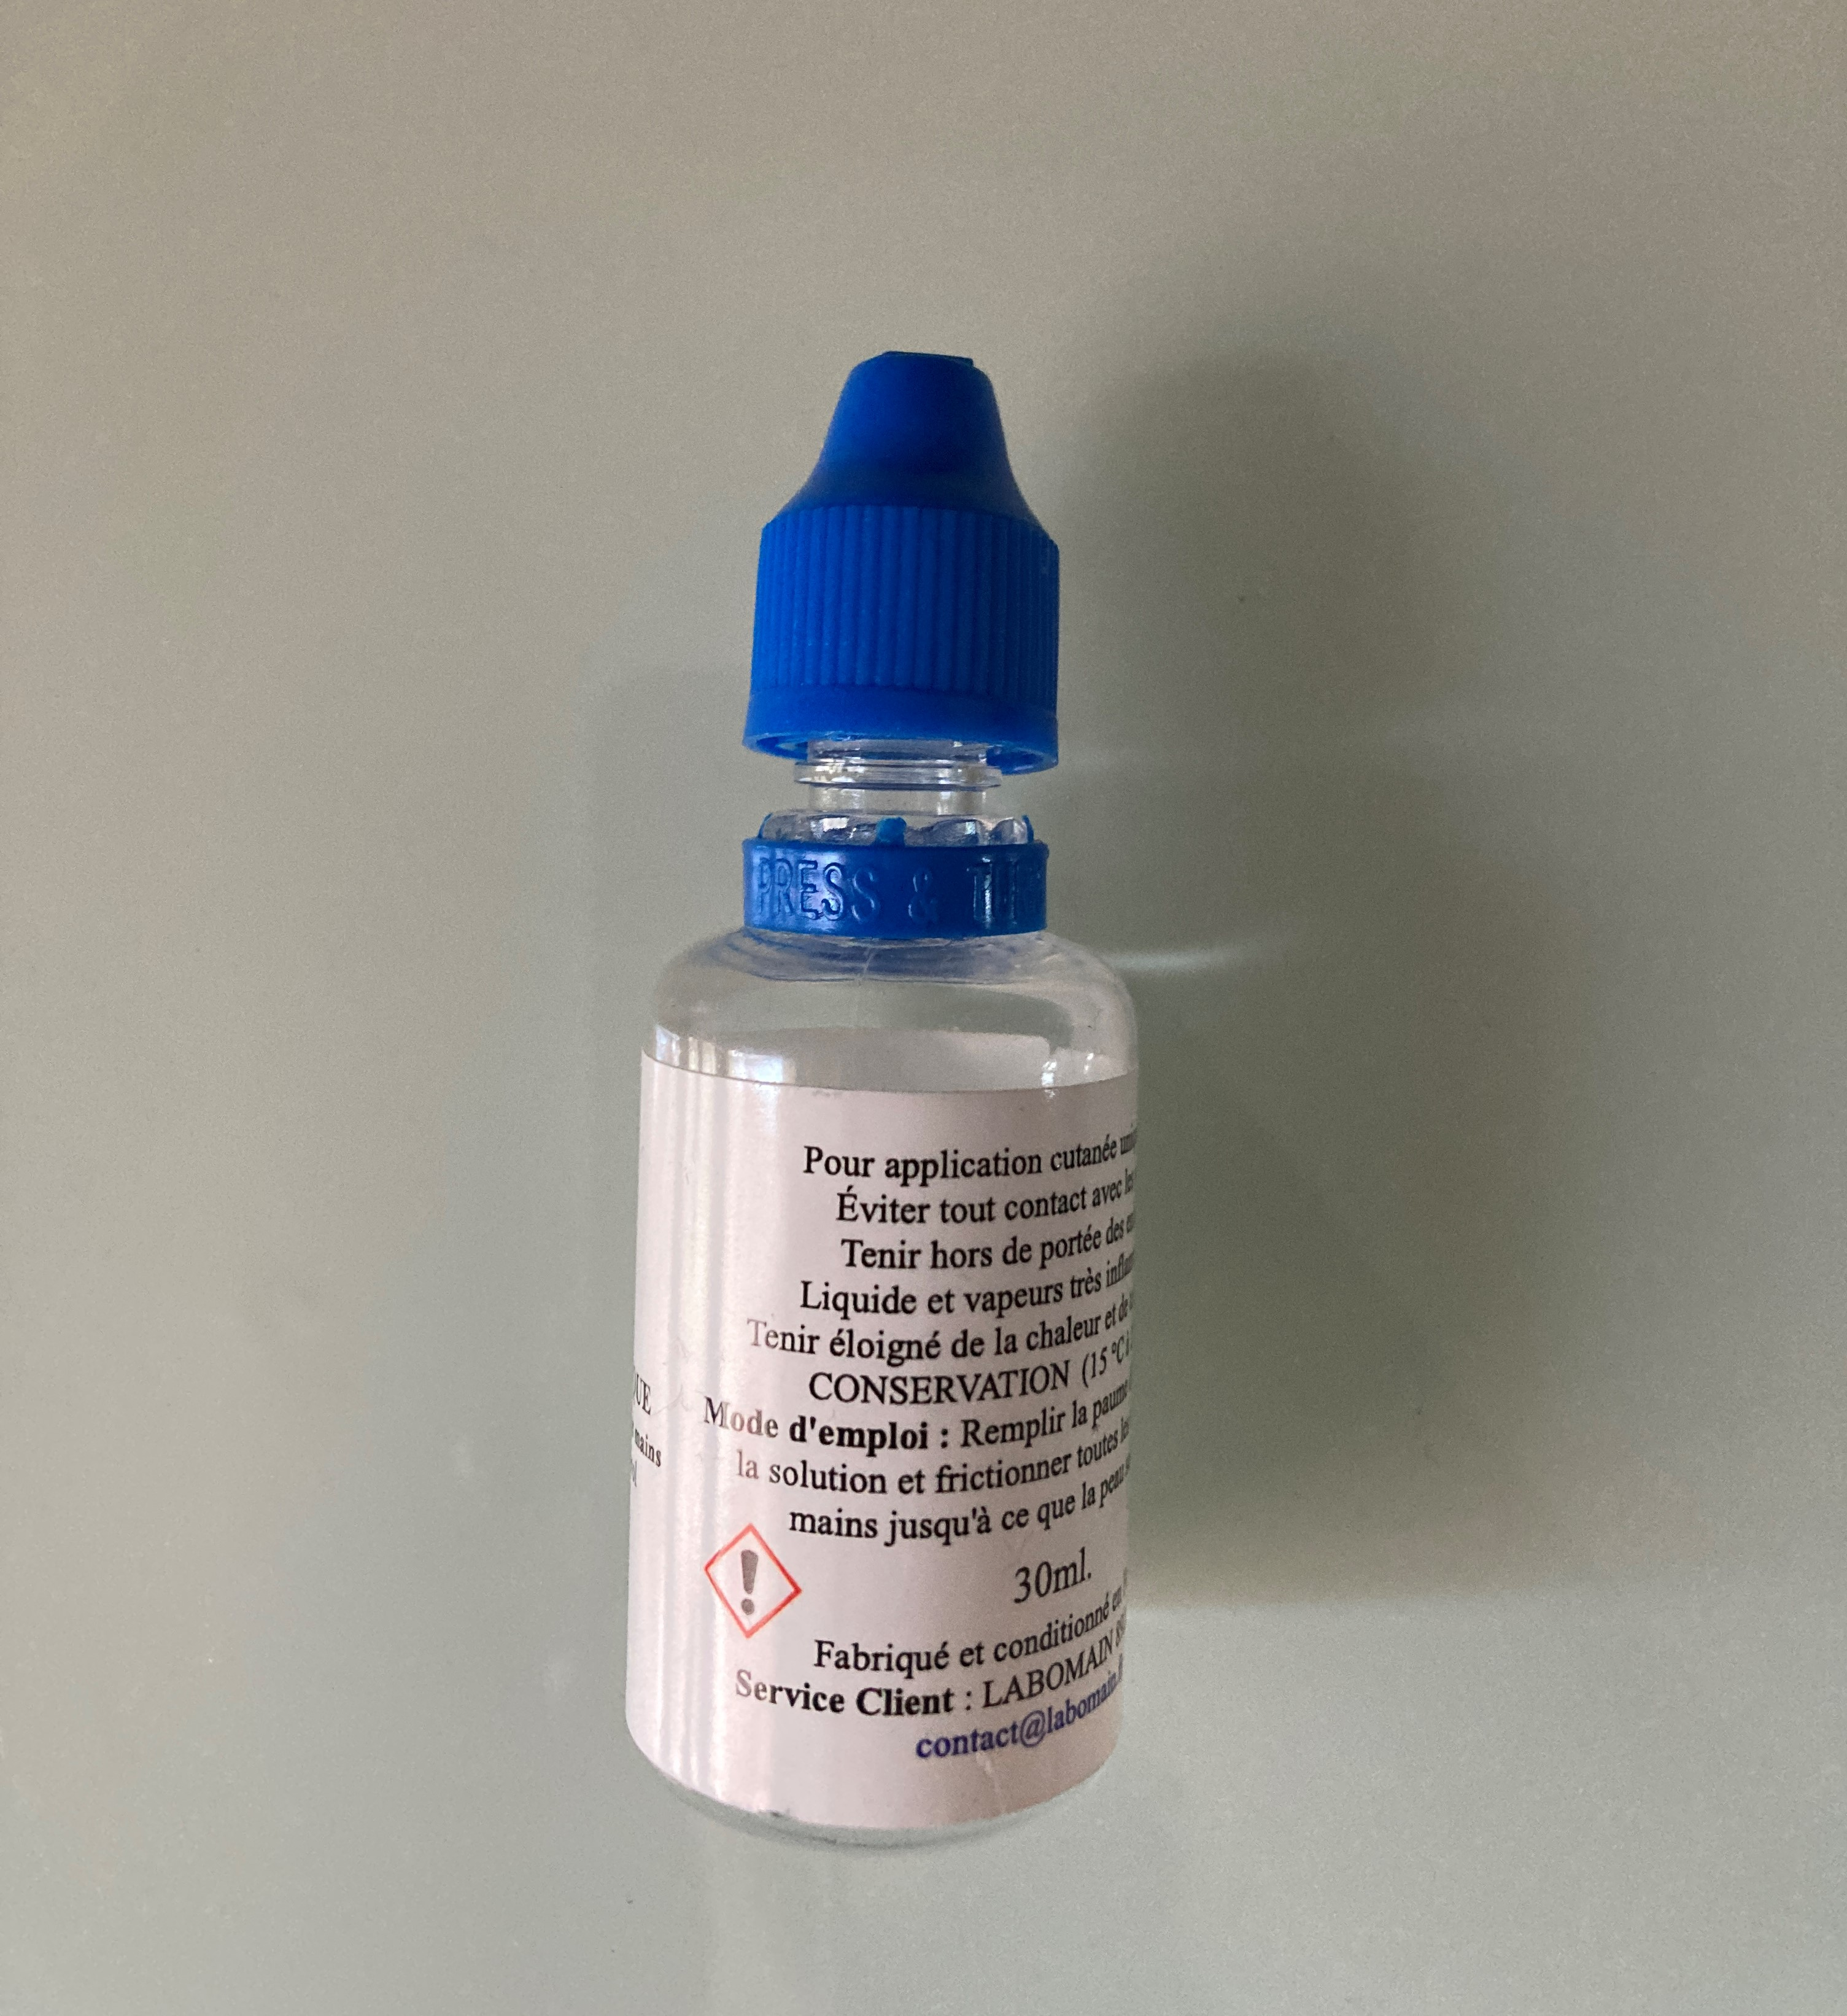

In [63]:
from IPython.display import Image
Image(filename=image_file)

In [64]:
import requests
# URL for the web service
scoring_uri = aks_service.scoring_uri
# If the service is authenticated, set the key or token
key, _ = aks_service.get_keys()
# Load image data
data = open(image_file, 'rb').read()
# Set the content type
headers = {'Content-Type': 'application/octet-stream'}
# If authentication is enabled, set the authorization header
headers['Authorization'] = f'Bearer {key}'
# Make the request and display the response
resp = requests.post(scoring_uri, data, headers=headers)
print("Calling the AKS deployed model...")
print("Status code=",resp.status_code)
print("\nElapsed=", resp.elapsed)
print("\nResults=", resp.text)

Calling the AKS deployed model...
Status code= 200

Elapsed= 0:00:00.968791

Results= {"filename": "/tmp/tmpppoos7f_", "boxes": [{"box": {"topX": 0.37283036163642547, "topY": 0.16918435096740722, "bottomX": 0.5978637278690273, "bottomY": 0.4718033313751221}, "label": "Cap KO", "score": 0.8059919476509094}]}



In [65]:
import json
detections = json.loads(resp.text) # Loading the predictions from the computer vision model
for detect in detections['boxes']:
    label = detect['label']
    box = detect['box']
    conf_score = detect['score']

## Visualize detections
Now that we have scored a test image, we can visualize the bounding boxes for this image

Cap KO: [1121.847, 555.601, 677.125, 993.801], 0.806


<Figure size 1296x864 with 0 Axes>

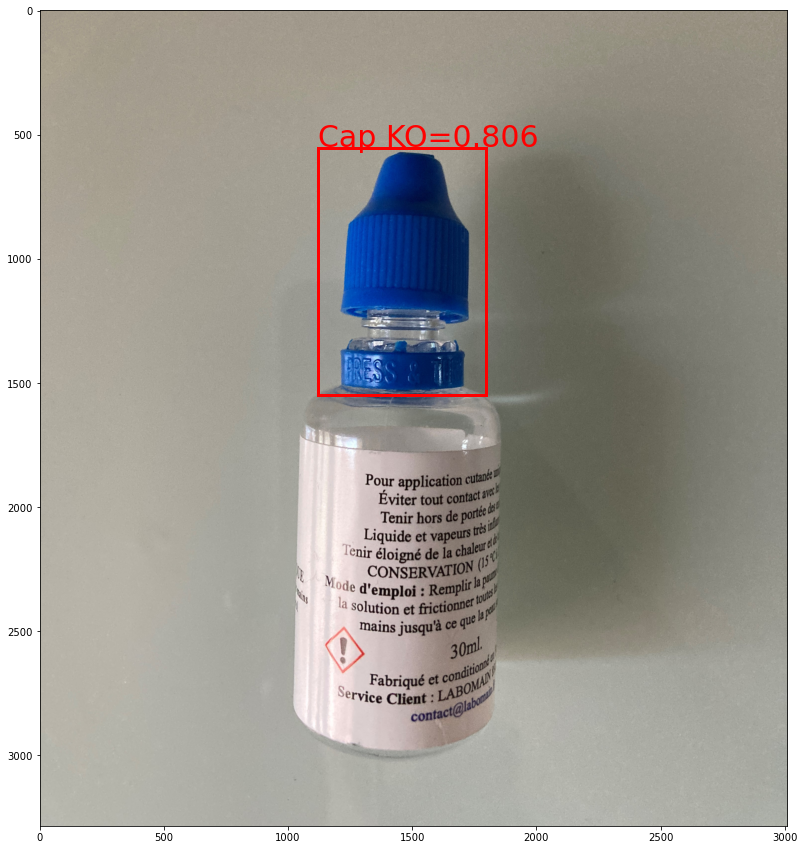

In [66]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from PIL import Image
import numpy as np
import json

IMAGE_SIZE = (18,12)
plt.figure(figsize=IMAGE_SIZE)
img_np=mpimg.imread(image_file)
img = Image.fromarray(img_np.astype('uint8'),'RGB')
x, y = img.size
fig,ax = plt.subplots(1, figsize=(15,15)) #You can change the size

# Display the image
ax.imshow(img_np)

minscore=0.5

# draw box and label for each detection 
detections = json.loads(resp.text) # Loadind the predictions from the computer vision model
for detect in detections['boxes']:
    label = detect['label']
    box = detect['box']
    conf_score = detect['score']
    if conf_score >= minscore: #Min probability
        ymin, xmin, ymax, xmax =  box['topY'],box['topX'], box['bottomY'],box['bottomX']
        topleft_x, topleft_y = x * xmin, y * ymin
        width, height = x * (xmax - xmin), y * (ymax - ymin)
        print('{}: [{}, {}, {}, {}], {}'.format(detect['label'], round(topleft_x, 3), 
                                                round(topleft_y, 3), round(width, 3), 
                                                round(height, 3), round(conf_score, 3)))
        if label=="Cap OK":
            color = "Green"
        
        if label=="Cap KO":
            color="red"
            
        rect = patches.Rectangle((topleft_x, topleft_y), width, height, 
                                 linewidth=3, edgecolor=color,facecolor='none')
        textdisp=label+'='+str(round(conf_score, 3))
        ax.add_patch(rect)
        plt.text(topleft_x, topleft_y - 10, textdisp, color=color, fontsize=30)       
        fig.savefig('predictiontest1.jpg', dpi=150) #Saving image
        
plt.show()

## Test 2

In [67]:
import urllib
image_url='https://github.com/retkowsky/AutoMLforImages/blob/main/images/CapTest2.jpg?raw=true'
image_file = 'test2.jpg'
urllib.request.urlretrieve(image_url, filename=image_file)
print("Image is downloaded and ready to be predicted.")

Image is downloaded and ready to be predicted.


In [68]:
import cv2 as cv
img = cv.imread(image_file)
print("Image informations:")
print("- Image filename:", image_file)
print("- Image shape:", img.shape)
print("- Image size:", img.size)

Image informations:
- Image filename: test2.jpg
- Image shape: (3160, 3009, 3)
- Image size: 28525320


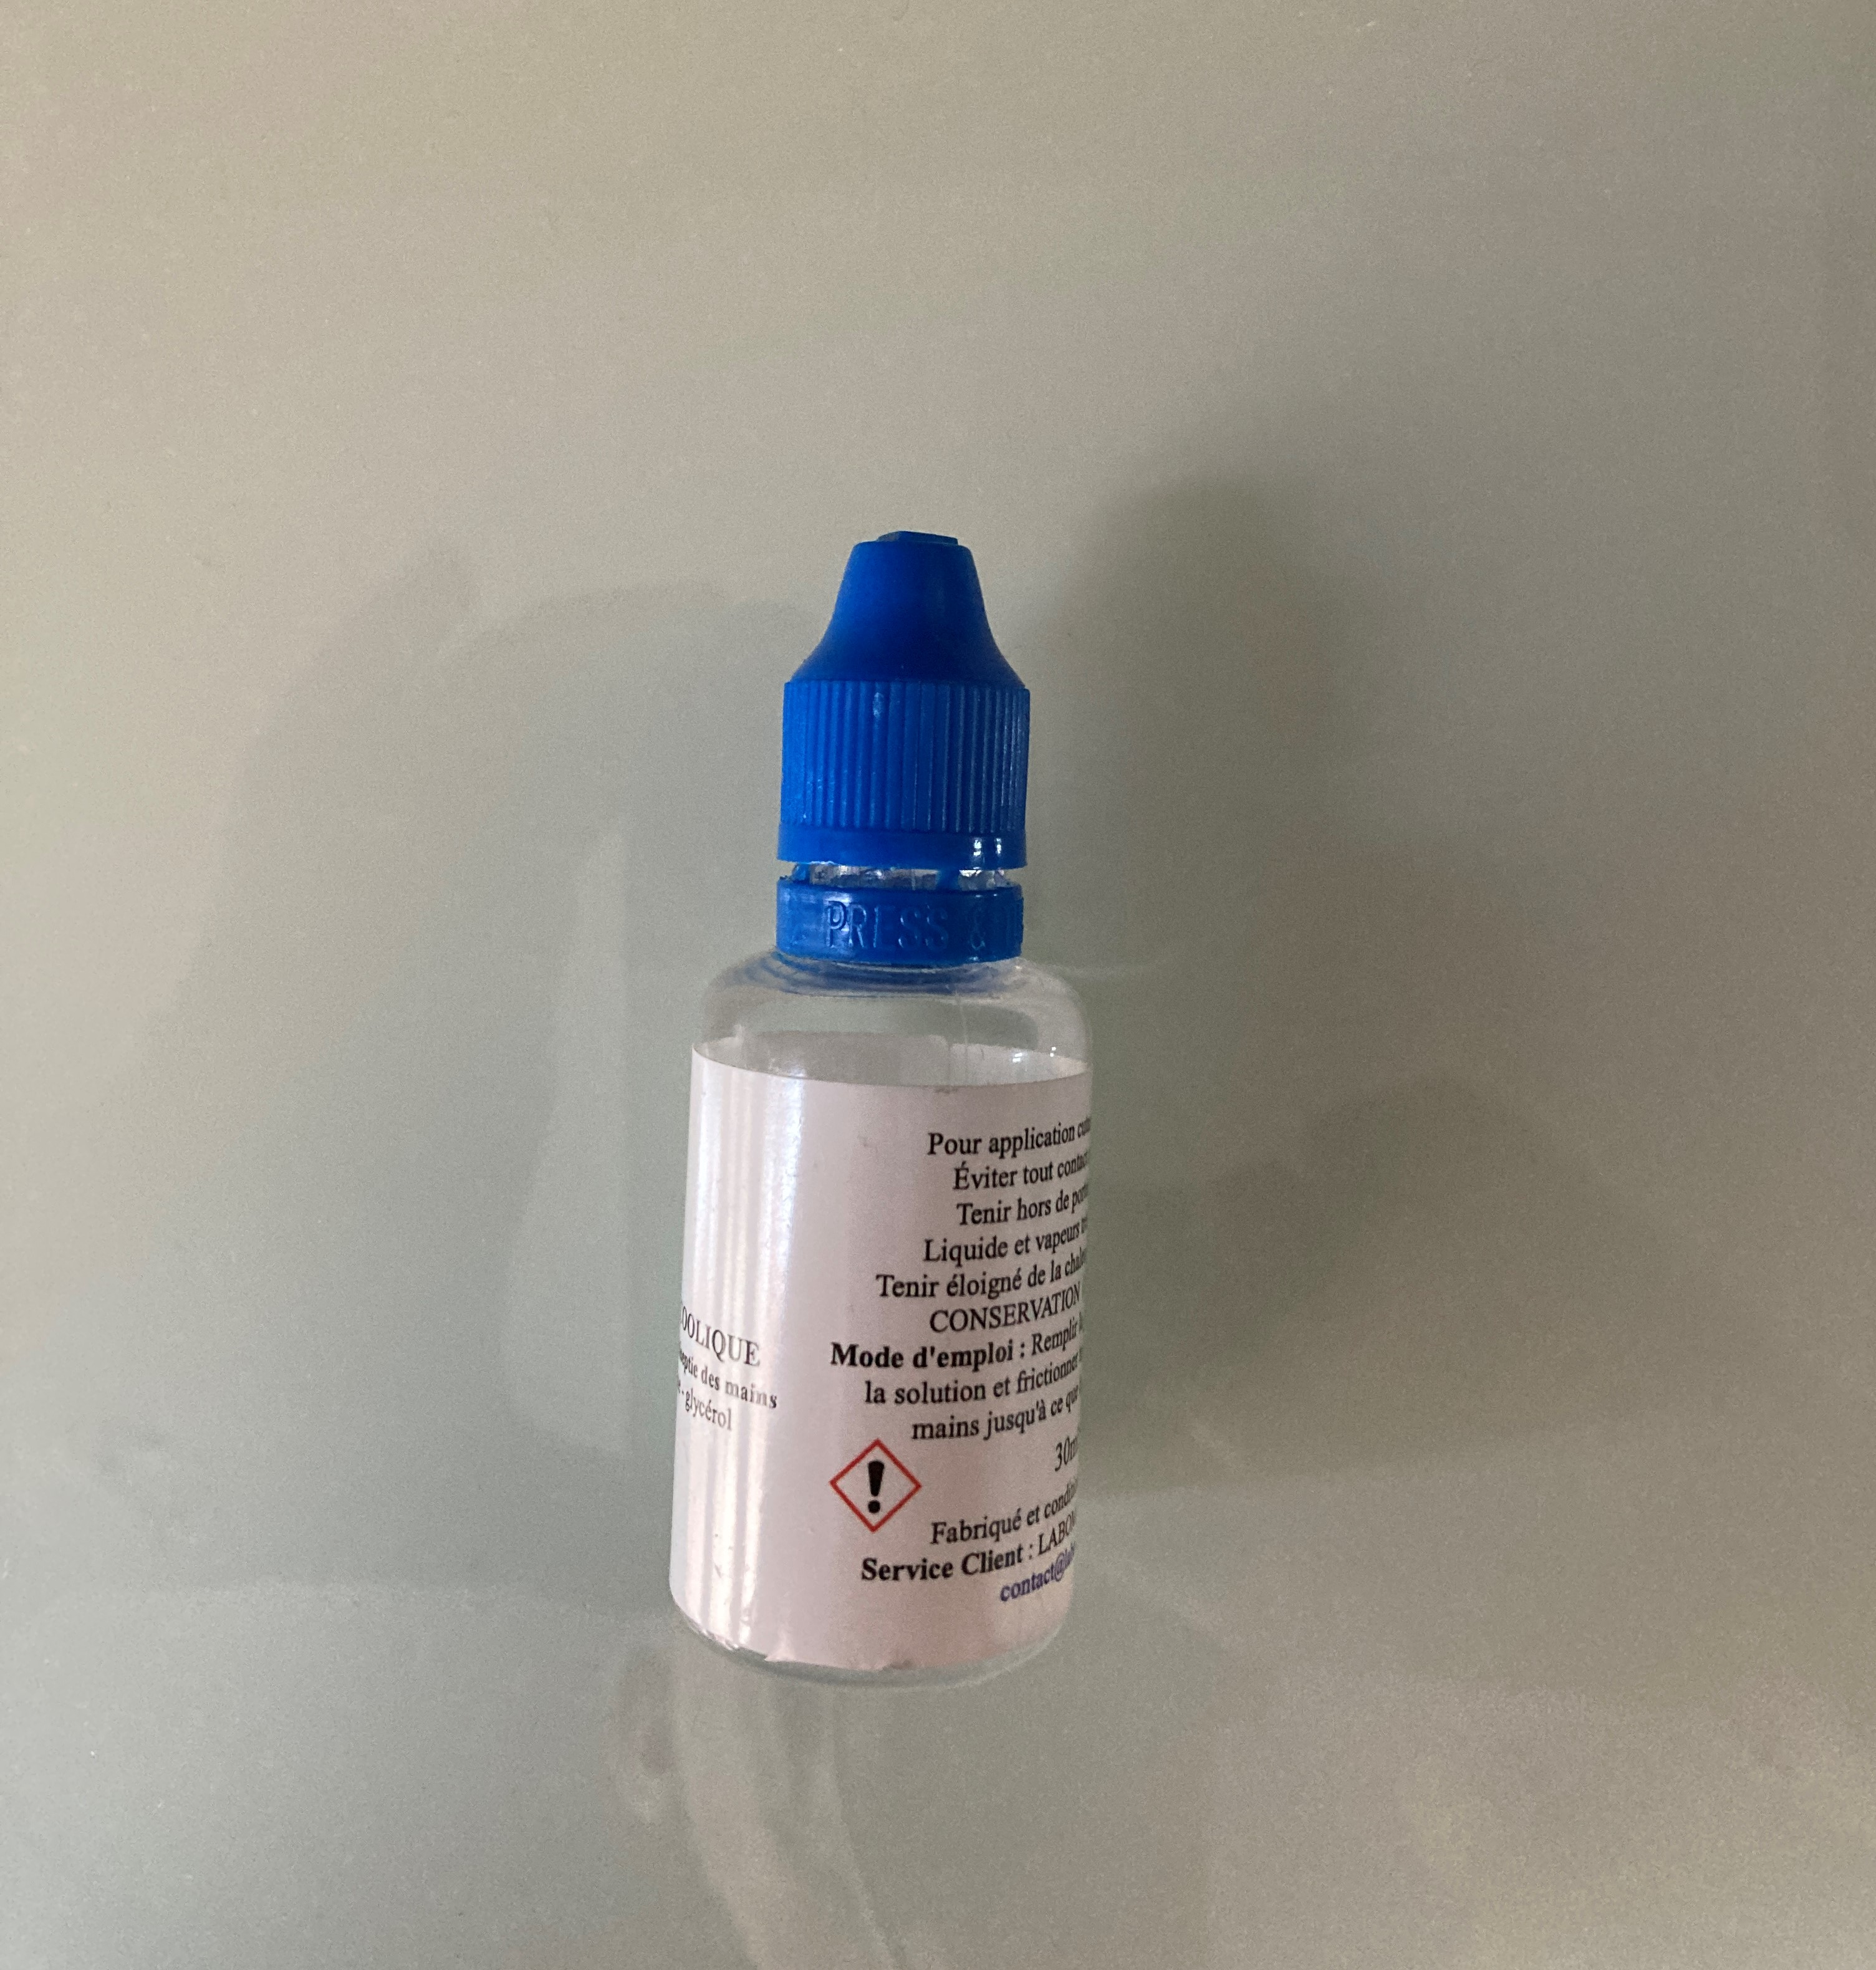

In [69]:
from IPython.display import Image
Image(filename=image_file)

In [70]:
import requests
# URL for the web service
scoring_uri = aks_service.scoring_uri
# If the service is authenticated, set the key or token
key, _ = aks_service.get_keys()
# Load image data
data = open(image_file, 'rb').read()
# Set the content type
headers = {'Content-Type': 'application/octet-stream'}
# If authentication is enabled, set the authorization header
headers['Authorization'] = f'Bearer {key}'
# Make the request and display the response
print("Calling the AKS deployed model...")
resp = requests.post(scoring_uri, data, headers=headers)
print("Status code=",resp.status_code)
print("\nElapsed=", resp.elapsed)
print("\nResults=", resp.text)

Calling the AKS deployed model...
Status code= 200

Elapsed= 0:00:01.045883

Results= {"filename": "/tmp/tmpgzhpuwc7", "boxes": [{"box": {"topX": 0.3980111057926673, "topY": 0.25983734130859376, "bottomX": 0.5536978585379464, "bottomY": 0.49814801216125487}, "label": "Cap OK", "score": 0.8390433192253113}]}



In [71]:
import json
detections = json.loads(resp.text) # Loadind the predictions from the computer vision model
for detect in detections['boxes']:
    label = detect['label']
    box = detect['box']
    conf_score = detect['score']

Cap OK: [1197.615, 821.086, 468.461, 753.062], 0.839


<Figure size 1296x864 with 0 Axes>

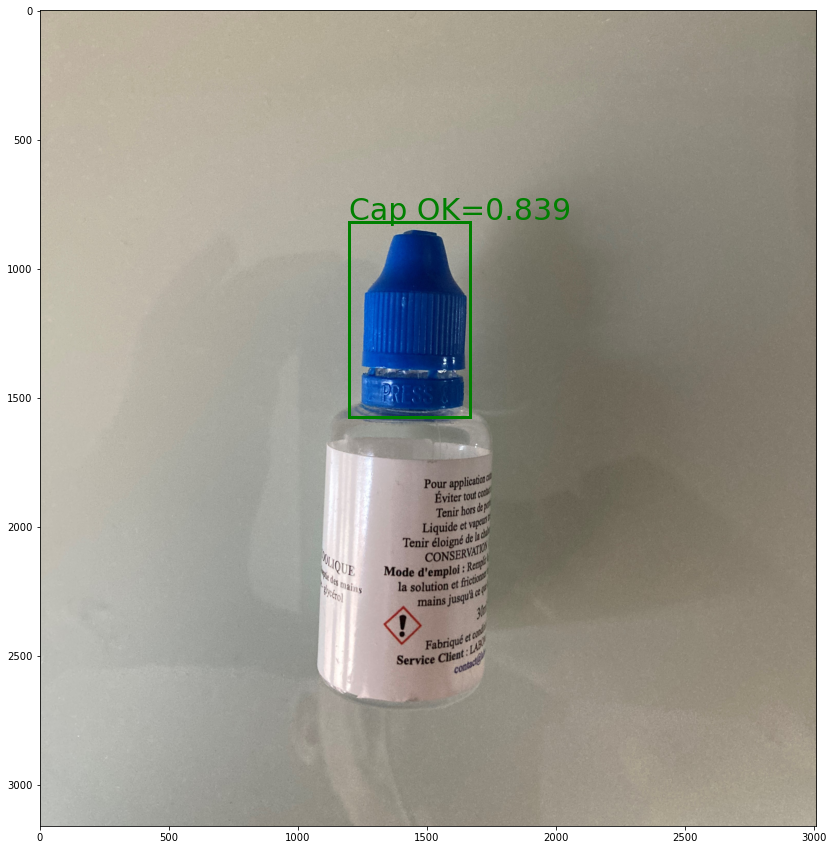

In [72]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from PIL import Image
import numpy as np
import json

IMAGE_SIZE = (18,12)
plt.figure(figsize=IMAGE_SIZE)
img_np=mpimg.imread(image_file)
img = Image.fromarray(img_np.astype('uint8'),'RGB')
x, y = img.size
fig,ax = plt.subplots(1, figsize=(15,15)) #You can change the size

# Display the image
ax.imshow(img_np)

minscore=0.5

# draw box and label for each detection 
detections = json.loads(resp.text) # Loading the predictions from the computer vision model
for detect in detections['boxes']:
    label = detect['label']
    box = detect['box']
    conf_score = detect['score']
    if conf_score >= minscore: #Min probability
        ymin, xmin, ymax, xmax =  box['topY'],box['topX'], box['bottomY'],box['bottomX']
        topleft_x, topleft_y = x * xmin, y * ymin
        width, height = x * (xmax - xmin), y * (ymax - ymin)
        print('{}: [{}, {}, {}, {}], {}'.format(detect['label'], round(topleft_x, 3), 
                                                round(topleft_y, 3), round(width, 3), 
                                                round(height, 3), round(conf_score, 3)))

        if label=="Cap OK":
            color = "Green"
        
        if label=="Cap KO":
            color="red"
            
        rect = patches.Rectangle((topleft_x, topleft_y), width, height, 
                                 linewidth=3, edgecolor=color,facecolor='none')
        textdisp=label+'='+str(round(conf_score, 3))
        ax.add_patch(rect)
        plt.text(topleft_x, topleft_y - 10, textdisp, color=color, fontsize=30)
        fig.savefig('predictiontest2.jpg', dpi=150) #Saving image
        
plt.show()

### Test 3

In [73]:
import urllib
image_url='https://github.com/retkowsky/AutoMLforImages/blob/main/images/CapTest3.jpg?raw=true'
image_file = 'test3.jpg'
urllib.request.urlretrieve(image_url, filename=image_file)
print("Image is downloaded and ready to be predicted.")

Image is downloaded and ready to be predicted.


In [74]:
import cv2 as cv
img = cv.imread(image_file)
print("Image informations:")
print("- Image filename:", image_file)
print("- Image shape:", img.shape)
print("- Image size:", img.size)

Image informations:
- Image filename: test3.jpg
- Image shape: (574, 953, 3)
- Image size: 1641066


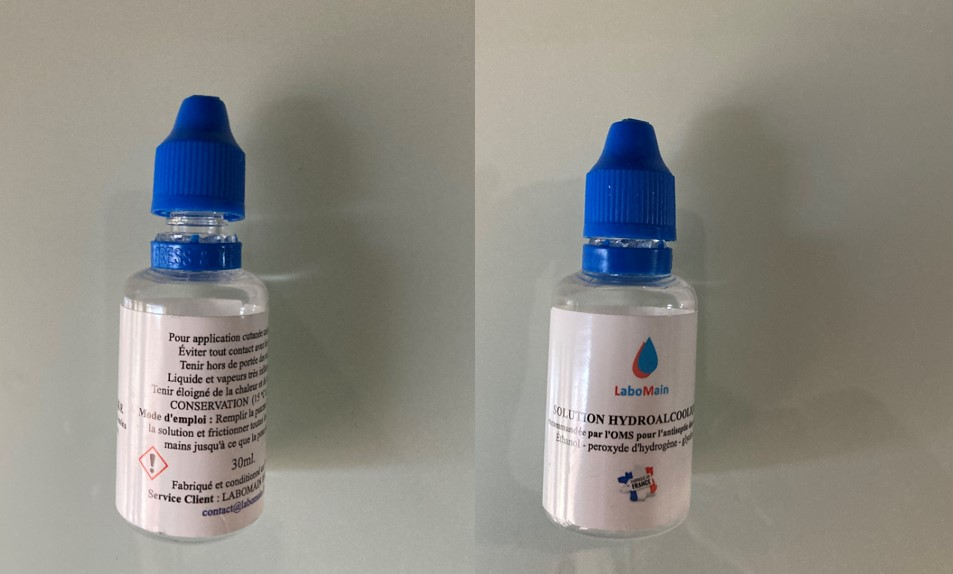

In [75]:
from IPython.display import Image
Image(filename=image_file)

In [76]:
import requests
# URL for the web service
scoring_uri = aks_service.scoring_uri
# If the service is authenticated, set the key or token
key, _ = aks_service.get_keys()
# Load image data
data = open(image_file, 'rb').read()
# Set the content type
headers = {'Content-Type': 'application/octet-stream'}
# If authentication is enabled, set the authorization header
headers['Authorization'] = f'Bearer {key}'
# Make the request and display the response
print("Calling the AKS deployed model...")
resp = requests.post(scoring_uri, data, headers=headers)
print("Status code=",resp.status_code)
print("\nElapsed=", resp.elapsed)
print("\nResults=", resp.text)

Calling the AKS deployed model...
Status code= 200

Elapsed= 0:00:00.470984

Results= {"filename": "/tmp/tmpmaosqxu5", "boxes": [{"box": {"topX": 0.594930362701416, "topY": 0.17006447531960228, "bottomX": 0.7264715194702148, "bottomY": 0.5072854574624595}, "label": "Cap OK", "score": 0.8957886099815369}, {"box": {"topX": 0.1557870626449585, "topY": 0.17223138189935064, "bottomX": 0.2598159074783325, "bottomY": 0.47842351740056815}, "label": "Cap KO", "score": 0.8301249742507935}]}



In [77]:
import json
detections = json.loads(resp.text) # Loadind the predictions from the computer vision model
for detect in detections['boxes']:
    label = detect['label']
    box = detect['box']
    conf_score = detect['score']

Cap OK: [566.969, 97.617, 125.359, 193.565], 0.896
Cap KO: [148.465, 98.861, 99.139, 175.754], 0.83


<Figure size 1296x864 with 0 Axes>

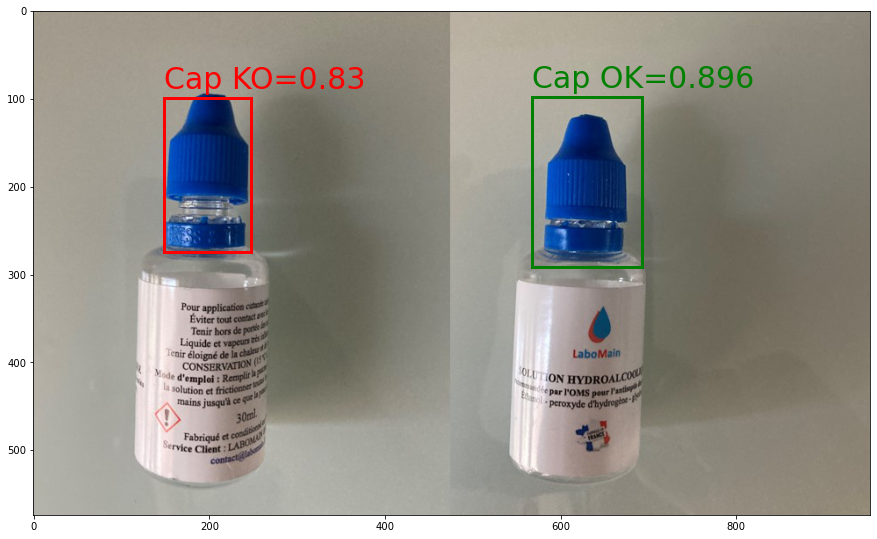

In [78]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from PIL import Image
import numpy as np
import json

IMAGE_SIZE = (18,12)
plt.figure(figsize=IMAGE_SIZE)
img_np=mpimg.imread(image_file)
img = Image.fromarray(img_np.astype('uint8'),'RGB')
x, y = img.size
fig,ax = plt.subplots(1, figsize=(15,15)) #You can change the size

# Display the image
ax.imshow(img_np)

minscore=0.5

# draw box and label for each detection 
detections = json.loads(resp.text) # Loading the predictions from the computer vision model
for detect in detections['boxes']:
    label = detect['label']
    box = detect['box']
    conf_score = detect['score']
    if conf_score >= minscore: #Min probability
        ymin, xmin, ymax, xmax =  box['topY'],box['topX'], box['bottomY'],box['bottomX']
        topleft_x, topleft_y = x * xmin, y * ymin
        width, height = x * (xmax - xmin), y * (ymax - ymin)
        print('{}: [{}, {}, {}, {}], {}'.format(detect['label'], round(topleft_x, 3), 
                                                round(topleft_y, 3), round(width, 3), 
                                                round(height, 3), round(conf_score, 3)))

        if label=="Cap OK":
            color = "Green"
        
        if label=="Cap KO":
            color="red"
        
        rect = patches.Rectangle((topleft_x, topleft_y), width, height, 
                                 linewidth=3, edgecolor=color,facecolor='none')
        textdisp=label+'='+str(round(conf_score, 3))
        ax.add_patch(rect)
        plt.text(topleft_x, topleft_y - 10, textdisp, color=color, fontsize=30)
        fig.savefig('predictiontest3.jpg', dpi=150) #Saving image
        
plt.show()

## 10. Cleanup ressources

In [79]:
aks_service.delete()
compute_target.delete()

> End of Notebook